# 1.7 Network graph visualization

## Importing libraries

In [84]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import matplotlib.pyplot as plt
from pyvis.network import Network
import seaborn as sns
import pyvis

In [42]:
# Import relationship data

relationship_df = pd.read_csv('/Users/ashwanisherawat/Downloads/Download/relationships.csv', index_col = 0)

In [43]:
relationship_df

,Entity 2,Sentence
Entity 1,,
Germany,Russia,The Bolsheviks negotiated the Treaty of Brest-...
Germany,Italy,"Germany, 1933\nFascism first appeared in Italy..."
Germany,Germany,When Adolf Hitler came to power in Germany in ...
France,Germany,"Britain and France, much to Hitler's surprise,..."
Germany,Italy,Both Germany and Italy declared war on the Uni...
France,Germany,"Rommel, who was now in charge of defending Fra..."
Germany,Italy,"On 27 September 1940, Japan became cosignatori..."
Russia,France,"Eventually, nine nations would overtly develop..."
Russia,China,"Eventually, nine nations would overtly develop..."


#### Graph visualization - Networkx

In [44]:
# Re-read the file with the first row as the header
relationship_df = pd.read_csv('/Users/ashwanisherawat/Downloads/Download/relationships.csv', delimiter=None, engine='python', header=0)

In [45]:
# Display the updated column names and first few rows
relationship_df.columns.tolist(), relationship_df.head()


(['Entity 1', 'Entity 2', 'Sentence'],
   Entity 1 Entity 2                                           Sentence
 0  Germany   Russia  The Bolsheviks negotiated the Treaty of Brest-...
 1  Germany    Italy  Germany, 1933\nFascism first appeared in Italy...
 2  Germany  Germany  When Adolf Hitler came to power in Germany in ...
 3   France  Germany  Britain and France, much to Hitler's surprise,...
 4  Germany    Italy  Both Germany and Italy declared war on the Uni...)

In [46]:
# Display the exact column names in the dataframe to check for issues
relationship_df.columns.tolist()


['Entity 1', 'Entity 2', 'Sentence']

In [47]:
# Create a static network graph using only NetworkX (no visualization libraries)

# Create an undirected graph for simplicity
G_static = nx.Graph()

In [51]:
# Create a graph from a pandas dataframe

G = nx.from_pandas_edgelist(relationship_df, 
                            source = "Entity 1", 
                            target = "Entity 2", 
                            edge_attr = "Sentence", 
                            create_using = nx.Graph())

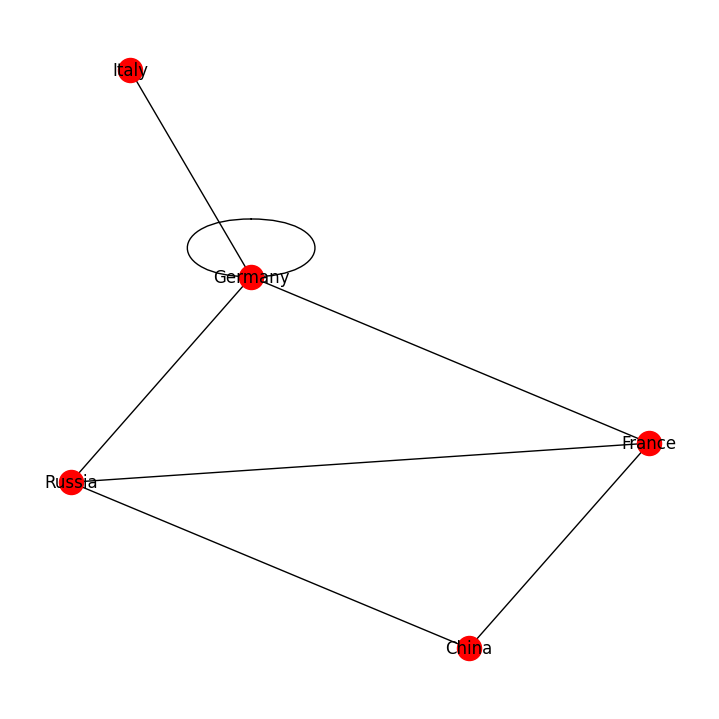

In [52]:
h = plt.figure(figsize = (7,7))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels = True, node_color = 'red', edge_cmap = plt.cm.Blues, pos = pos)
plt.show() 

In [57]:
h.savefig('networkx_plt_alice.png')

#### Graph visualization - Pyvis

In [58]:
# Create a PyVis network object
net = Network(height="750px", width="100%", notebook=True, directed=False)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [59]:
# Add nodes and edges to the PyVis network from the NetworkX graph
for node in G_static.nodes():
    net.add_node(node, label=node)

for source, target, data in G_static.edges(data=True):
    sentence = data.get('sentence', '')
    net.add_edge(source, target, title=sentence)



In [60]:
# Set options for better visualization
net.set_options("""
var options = {
  "nodes": {
    "font": {
      "size": 16
    },
    "shape": "dot",
    "size": 20
  },
  "edges": {
    "arrows": {
      "to": {
        "enabled": false
      }
    },
    "color": {
      "inherit": true
    },
    "smooth": false
  },
  "physics": {
    "enabled": true,
    "stabilization": {
      "iterations": 100
    }
  }
}
""")



In [67]:
output_path = "interactive_country_relationships.html"
net.save_graph(output_path)


## Applying the Leiden algorithm to detect any communities within the countries.

In [81]:
# Install necessary libraries (if not already installed)
# !pip install cdlib leidenalg igraph

import networkx as nx
import igraph as ig
from cdlib import algorithms

In [90]:
# Convert the NetworkX graph to an iGraph object
igraph_graph = ig.Graph.TupleList(G_static.edges(), directed=False)

In [91]:
!pip install cdlib leidenalg igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.4 MB/s eta 0:00:00a 0:00:01


In [92]:
# Apply the Leiden algorithm using the iGraph object
leiden_communities = algorithms.leiden(igraph_graph)

In [94]:
# Extract community membership information
community_result = leiden_communities.communities

In [95]:
# Display the detected communities
community_result

[['Russia', 'France', 'China'], ['Germany', 'Italy']]

In [96]:
from cdlib import algorithms
coms = algorithms.leiden(G)

In [97]:
type(coms)

cdlib.classes.node_clustering.NodeClustering

In [98]:
new_com = coms.to_node_community_map()

In [99]:
new_com

defaultdict(list,
            {'Russia': [0],
             'France': [0],
             'China': [0],
             'Germany': [1],
             'Italy': [1]})

In [100]:
# Put the output from new_com into a dictionary

dict_com = {k:v[0] for k,v in new_com.items()}

In [101]:
dict_com

{'Russia': 0, 'France': 0, 'China': 0, 'Germany': 1, 'Italy': 1}

In [102]:
# Rerun network graph with the communities as an argument

nx.set_node_attributes(G, dict_com, 'group')
com_net = Network(notebook = True, width="1300px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show_buttons(filter_ = True)
com_net.repulsion()
com_net.show("interactive_communities_country_relationships.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


## The most important characters in 20th Century 

In [103]:
# Degree centrality

degree_dict = nx.degree_centrality(G)
degree_dict

{'Germany': 1.25, 'Russia': 0.75, 'Italy': 0.25, 'France': 0.75, 'China': 0.5}

In [104]:
degree_df = pd.DataFrame(degree_dict.items(), columns=['characters','centrality'])

In [105]:
degree_df.sort_values(by = ['centrality'], ascending=False, inplace = True)

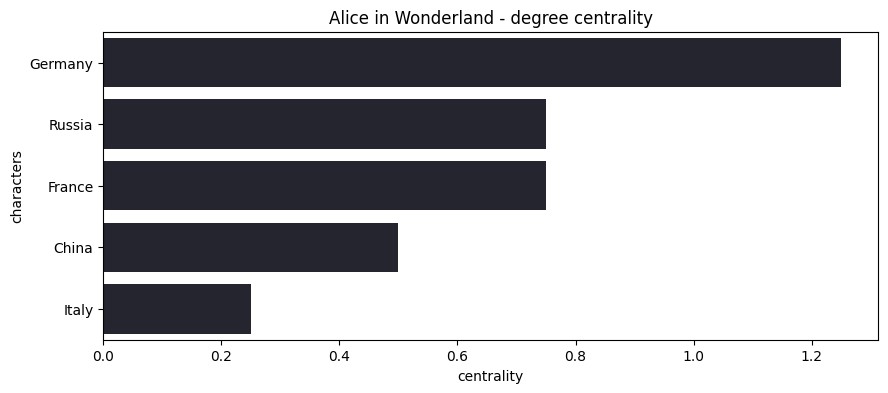

In [106]:
# Plot the degree centrality

plt.figure(figsize = (10, 4))
with sns.dark_palette("xkcd:blue", 22):
    sns.barplot(x = "centrality", y = "characters",
    saturation = 0.9, data = degree_df).set_title("Alice in Wonderland - degree centrality")

In [107]:
# Closeness centrality

closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(closeness_dict.items(), columns=['characters','centrality'])

In [108]:
closeness_df.sort_values(by = ['centrality'], ascending=False, inplace = True)

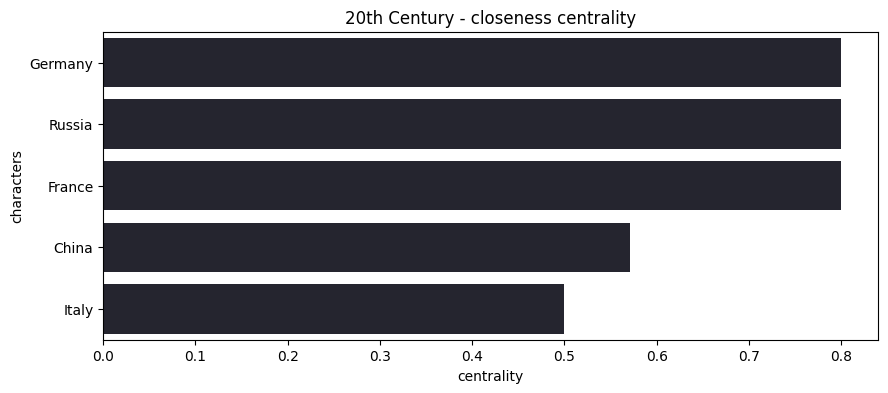

In [109]:
plt.figure(figsize = (10, 4))
with sns.dark_palette("xkcd:blue", 22):
    sns.barplot(x = "centrality", y = "characters",
    saturation = 0.9, data = closeness_df).set_title("20th Century - closeness centrality")

In [110]:
# Betweenness centrality

betweenness_dict = nx.betweenness_centrality(G)
betweennes_df = pd.DataFrame(betweenness_dict.items(), columns=['characters','centrality'])

In [111]:
betweennes_df.sort_values(by = ['centrality'], ascending=False, inplace = True)

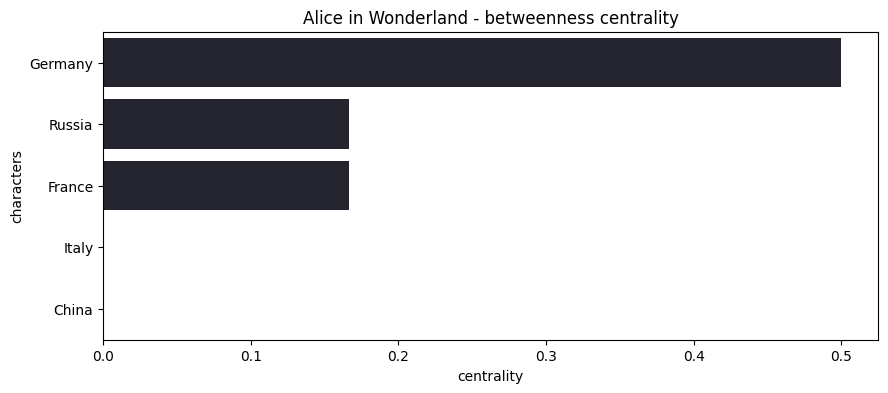

In [112]:
plt.figure(figsize = (10, 4))
with sns.dark_palette("xkcd:blue", 22):
    sns.barplot(x = "centrality", y = "characters",
    saturation = 0.9, data = betweennes_df).set_title("Alice in Wonderland - betweenness centrality")

In [113]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')